# Bayesian methods for machine learning - Week 2

## Probabilistic modelling

The main advantages of probabilistic modelling with respect to other machine learning techniques are mainly two:

- They can easily deal with missing data.
- They quantify uncertainty. While linear regression or neural networks retrieve the maximum likelihood estimator, they do not provide a measure of the uncertainty of the prediction.

## Latent variables (interview example)

Latent variables are random variables in the model that are not directly observed (e.g. intelligence, empathy).

Let's present the example in the lecture: imagine we design a hiring process where several attributes of the candidate are gathered (e.g. GPA, interview score) and use to predict the onsite interview score, so only candidates more likely to score best in the interview are to be brought onsite. We can map the model into a Bayesian network:

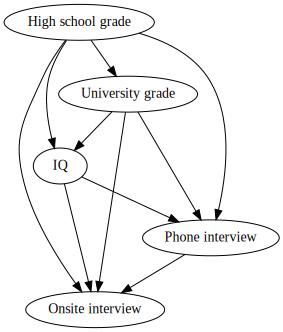

In [42]:
from graphviz import Digraph
import itertools

nodes = [
    ('H', 'High school grade'),
    ('U', 'University grade'),
    ('Q', 'IQ'),
    ('P', 'Phone interview'),
    ('O', 'Onsite interview')   
]

bn = Digraph()

for node_info in nodes:
    bn.node(*node_info)
    
edges_info = list(itertools.combinations(nodes, 2))
for node_1, node_2 in edges_info:
    bn.edge(node_1[0], node_2[0])

bn

Some examples of historical data may be:

|          | High school grade | University grade | IQ score | Phone interview | Onside interview |
|----------|-------------------|------------------|----------|-----------------|------------------|
| Daphne   | 3.8               | 4.0              | 135      | 4/5             | 95/100           |
| Geoffrey | 3.4               | 3.9              | 125      | 4/5             | 90/100           |
| Yoshua   | 4.0               | 3.8              | 150      | 3/5             | 85/100           |

And for new data, we have:

|          | High school grade | University grade | IQ score | Phone interview | Onside interview |
|----------|-------------------|------------------|----------|-----------------|------------------|
| Hilbert  | 3.7               | 4.0              | 140      | 3/5             | ?                |
| Turing   | 3.9               | 4.0              | 145      | 4/5             | ?                |


For each participant we would obtain a probability distribution over values of `Onside interview`:

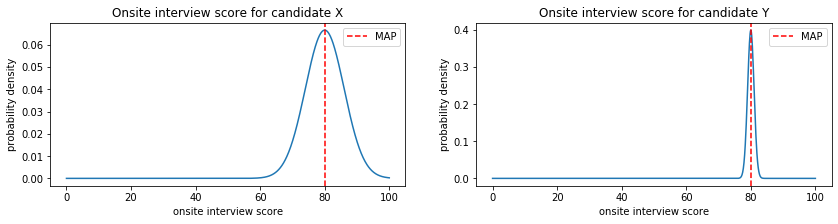

In [38]:
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np

def _plot(mu: float, sigma: float, ax, candidate_name: str) -> None:
    xs = np.linspace(0, 100, 1000)
    ax.plot(
        xs,
        scipy.stats.truncnorm(a=(0 - mu) / sigma,
                              b=(100 - mu) / sigma,
                              loc=mu,
                              scale=sigma).pdf(xs)
    )
    ax.set_xlabel('onsite interview score')
    ax.set_ylabel('probability density')
    ax.set_title(f'Onsite interview score for candidate {candidate_name}')
    ax.axvline(mu, linestyle='--', color='red', label='MAP')
    ax.legend()
    
_, axs = plt.subplots(1, 2, figsize=(14, 3))
_plot(80, sigma=6, ax=axs[0], candidate_name='X')
_plot(80, sigma=1, ax=axs[1], candidate_name='Y')

Other methods such as linear regression or neural networks would usually provide an estimation of the plotted MAP. However, they would fail to provide uncertainty around this value. Note that two candidates with same MAP may have highly different uncertainty on their score, which may lead us to different considerations about their applications.

### Training and inference issues

The Bayesian Network defined in the example is very little structure and introduced dependencies between all pairs of variables. This would require either:

- Defining a table with all thousands of possible combinations of values of the random variables:

| High school grade | University grade | IQ score | Phone interview | Onside interview | Probability |
|-------------------|------------------|----------|-----------------|------------------|-------------|
| 1.0               | 1.0              | 1.0      | 0/5             | 0/100            | 0.006       |
| 1.0               | 1.0              | 1.0      | 0/5             | 1/100            | 0.0005      |
| ...               | ...              | ...      | ...             | ...              | ...         |

Which is impractical.

- Define a probabilistic model by modelling joint probability:

$$
P(H, U, Q, P, O) = \frac{f(x)}{Z}
$$

Where $f(x)$ is a function of the inputs and $Z$ is the normalization constant. The normalization constant is the sum of probabilities for all possible configurations, which grows exponentially with the number of variables involved. In this example, considering variables are discrete, they already sum up to more than a million. Though we have drastically reduced the number of parameters, computing $Z$ for training and inference is impractical.

### Introducing latent variables

We can add a latent unobserved variable that relates to all of this variables, such as the *Intelligence*:

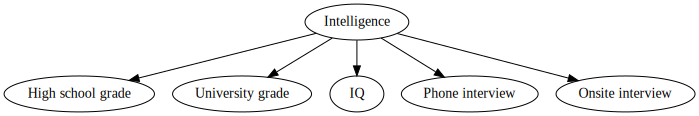

In [43]:
nodes = [
    ('H', 'High school grade'),
    ('U', 'University grade'),
    ('Q', 'IQ'),
    ('P', 'Phone interview'),
    ('O', 'Onsite interview')
]

bn = Digraph()

for node_info in nodes:
    bn.node(*node_info)

bn.node('E', 'Intelligence')
    
for node_idx, _ in nodes:
    bn.edge('E', node_idx)

bn

By adding this variable:
    
- Each original variable is conditionally independet to one another given `Intelligence`.
- Joint probability can be modelled in a simpler way by marginalization:
    
$$
P(H, U, Q, P, O) = \sum_{i \in I} P(H, U, Q, P, O|I=i)P(I=i)
$$

Which at the same time can be factorized into smaller factors using the conditionally independence introduced:

$$
P(H, U, Q, P, O) = \sum_{i \in I} P(H|I=i)P(U|I=i)P(Q|I=i)P(P|I=i)P(O|I=i)P(I=i)
$$

By doing so we have moved from more > 1M parameters to potentially several thousands keeping the model flexibility. Now, we just have to model individual interactions between each variable and the latent one.

However, traning and inference using latent variables adds mathematical complexity to the processes.